# 고양이 수염 스티커 만들기

## 1. 스티커와 사진 구하기
고양이 수염 이미지를 다운로드 받고, 셀카 이미지를 촬영한다. 셀카 이미지를 OpenCV로 불러와 이미지 가로 세로의 비율에 따라 변경한다.

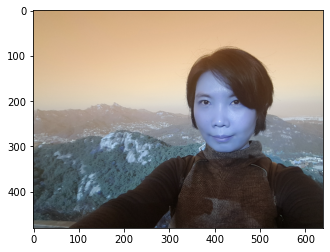

In [1]:
# import cv2, matplotlib, numpy, os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# 이미지 읽기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/2.jpg'
img_bgr = cv2.imread(my_image_path) #- OpenCV로 이미지를 읽기
img_bgr = cv2.resize(img_bgr, (640, 480)) # 640x480 의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv는 BGR을 사용하므로 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은 색으로 바뀌어 출력한다. 따라서 RGB로 색깔 보정처리를 한다. 

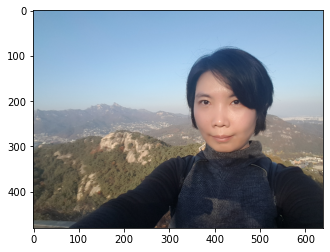

In [2]:
# 색 보정처리
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 & 랜드마크 검출 

### 1) bound box 위치 찾기     
detector를 사용해 얼굴의 bounding box를 찾고, cvtColor()를 이용하여 opencv의 BRG 이미지를 RGB로 바꾸었다. detector_hog의 두 번째 파라미터는 이미지 파라미터의 수인데, 이미지를 upsampling 방법으로 크기를 키우는 것을 의미한다. 

In [3]:
# dlib활용한 hog detcter 선언
import dlib
detector_hog = dlib.get_frontal_face_detector() #- detector 선언
print("🌫🛸")

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # BRG -> RGB
dlib_rects = detector_hog(img_rgb, 1) #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸
🌫🛸


찾은 얼굴을 화면에 출력한다. dlib detector는 dlib.rectangles 타입의 객체를 반환하고, dib.rectangle 객체는 left(), top(), right(), bottom() 등 멤버함수를 포함한다. 

rectangles[[(339, 167) (494, 322)]]


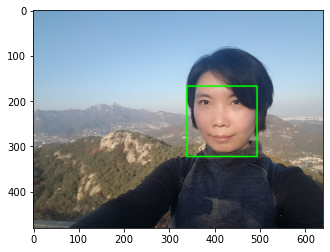

In [4]:
# 찾은 얼굴 영역을 좌표로 표시
print(dlib_rects) 
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 얼굴 인식이 되지 않는 사진이 있었는데, 이미지의 사이즈를 변경해 주자 bounding box가 나왔다.

### 2) landmark 위치 찾기     
이목구비의 위치를 추론하는 것은 face landmark localization 기술이며, face landmark는 bounding box로 잘라낸 얼굴 이미지를 사용한다. 여기서는 bottom-up 알고리즘(전체의 keypoint를 먼저 찾고 point의 관계를 군집화하여 box를 생성)과 Dlib의 제공되는 모델(300-W 데이터셋으로 학습한 pretrained model)을 사용하였다. 

In [5]:
# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

# landmark predictor
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) # .part():(x,y)형태로 접근하도록 변환
    list_landmarks.append(list_points) #list_points: tuple(x,y) 68개로 이루어진 리스트

print(len(list_landmarks[0])) #68개 랜드마크가 저장된 list_landmark

🌫🛸
68


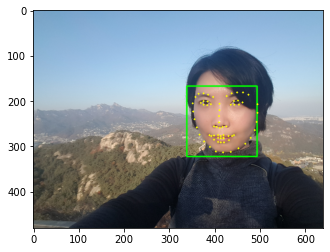

In [6]:
# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인
스티커를 적용하려면 얼굴위치, 카메라의 거리에 따라 픽셀 x가 다르므로 비율로 계산해야 한다. 계산할 수치는 스티커 위치와 스티커 크기이다. 코(30)를 기준점으로 잡고, (코와 눈꼬리(36)사이의 거리)\*2를 너비, (입꼬리(48)와 볼(2)사이의 거리)\*2)를 높이로 계산하였다. (숫자로만 생각하려니 상상이 잘 안 되어서 landmark 좌표를 띄워놓은 후 그림을 그려 계산했다.)

[Facial landmark]<img src="https://cdn-images-1.medium.com/max/800/1*96UT-D8uSXjlnyvs9DZTog.png" width="300px" height="300px">

In [7]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] 
    w = (landmark[30][0] - landmark[36][0])*2
    h = (landmark[48][1] - landmark[2][1])*2
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(410, 247)
(x,y) : (410,247)
(w,h) : (80,70)


스티커 이미지를 읽고 위에서 계산한 크기(너비와 높이)로 사이즈를 변경하였다.

In [8]:
# 스티커 이미지를 읽어 resize 
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)  # 스티커 이미지 읽기
img_sticker = cv2.resize(img_sticker, (w,h))  # 이미지 resize
print (img_sticker.shape)

(70, 80, 3)


원본 이미지에 스티커 이미지를 추가하기 위해 x, y좌표를 조정하였다. 이미지의 시작점은 top-left이다. 여기서는 조정된 x, y좌표가 모두 양수이므로 음수에 대한 예외처리를 하지 않았다. (x, y의 좌표를 조정하는 부분도 쉽지 않아 그림을 그려 계산하였다.)
- 참고로 음수에 대한 예외처리(범위 벗어난 부분 자르기)의 코드는 ```img_sticker = img_sticker[-refined_y:]```이다.

In [9]:
# x, y 좌표 조정
refined_x = x - w // 2 # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (370,212)


## 4. 스티커 적용    
원본 이미지에 크기가 조정된 스티커를 적용한다. sticker_area는 원본이미지에서 스티커를 적용할 위치를 잘라낸 이미지이다. 여기서는 (370, 212)~(370+80,212+70)범위의 이미지이다. sticker_area에서는 (y,x)로 표현됨을 주의해야 한다.       
스티커 이미지에서 사용할 부분은 색이 있는 부분이고, 나머지 바탕은 투명하게 바꾸어야 하므로 img_sticker가 255인 부분은 sticker_area를 사용하고, 255가 아닌 부분은 img_sticker에 적용한다. (np.where(조건, 조건이 참, 조건이 참이 아닌 경우)이며, 여기서는 조건이 참인 경우 기존 이미지 그대로, 조건이 참이 아닌 경우는 스티커 이미지를 대입하도록 되어 있다.)

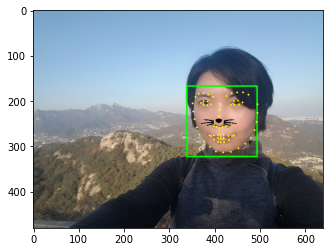

In [10]:
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_show 대신 img_rgb를 사용함으로써, bounding box와 landmark를 제거하여 최종 결과물을 출력한다. 

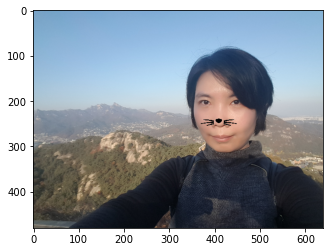

In [11]:
# bounding box, landmark 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### - 이미지 블렌딩: opencv 의 cv2.addWeighted() 사용

스티커를 자연스럽게 보이기 위해서는 스티커 뒤로 원본이미지가 같이 보이도록 해야 한다. cv2.addWeighted()를 참고하여 스티커와 원본이미지를 블렌딩하였다. cv2.addWeighted()는 같은 크기의 이미지끼리 사용가능하므로 같은 크기인 sticker_area와 img_sticker를 블렌딩하였다. 

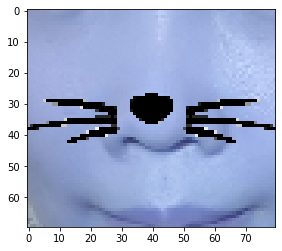

In [13]:
added_image = cv2.addWeighted(img_sticker, 0.1,sticker_area,0.9, 0)
plt.imshow(added_image)
plt.show()

블렌딩한 이미지를 원본 이미지에 붙여 주었다. 블렌딩한 이미지가 원본이미지와 색이 달라 붙인 티가 나서 최대한 티가 안 나도록 위의 코드에서 cv2.addWeighted()의 숫자를 조정하였다.

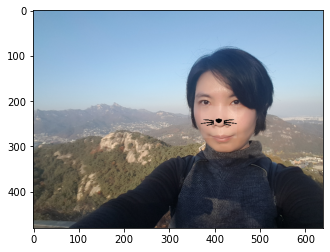

In [14]:
sticker_area = img_bgr[refined_y:refined_y+added_image.shape[0], refined_x:refined_x+added_image.shape[1]]
img_bgr[refined_y:refined_y+added_image.shape[0], refined_x:refined_x+added_image.shape[1]] = \
    np.where(added_image==255,sticker_area,added_image).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 다른 각도의 사진

얼굴의 각도가 변할 때 스티커가 어떻게 적용되는지 알아보기 위해서 얼굴이 기울어진 사진으로 스티커를 적용하였다. 

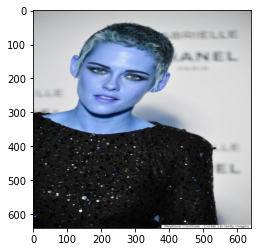

In [15]:
# 이미지 읽기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/st.jpeg'
img_bgr = cv2.imread(my_image_path) #- OpenCV로 이미지를 읽기
img_bgr = cv2.resize(img_bgr, (640, 640)) # 640x640 의 크기로 Resize
img_show = img_bgr.copy() #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

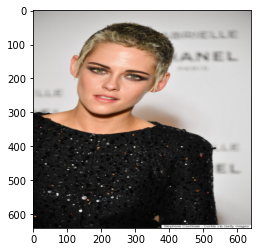

In [16]:
# 색 보정처리
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 & 랜드마크 검출 

### 1) bound box 위치 찾기

In [17]:
# dlib활용한 hog detcter 선언
import dlib
detector_hog = dlib.get_frontal_face_detector() #- detector 선언
print("🌫🛸")

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸
🌫🛸


rectangles[[(139, 118) (324, 304)]]


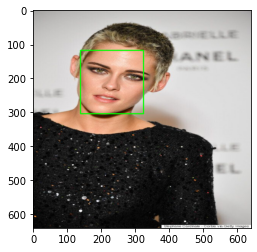

In [18]:
# 찾은 얼굴 영역을 좌표로 표시
print(dlib_rects) 
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2) landmark 위치 찾기 

In [19]:
# landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

# landmark predictor
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

🌫🛸
68


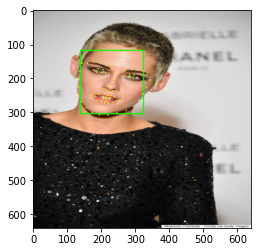

In [20]:
# 랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴의 각도가 변하여도 bounding box와 landmark는 잘 찾는 것을 알 수 있다.

## 3. 스티커 적용 위치 확인

In [21]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] 
    w = (landmark[30][0] - landmark[36][0])*2
    h = (landmark[48][1] - landmark[2][1])*2
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(228, 225)
(x,y) : (228,225)
(w,h) : (102,98)


In [22]:
# 스티커 이미지를 읽어 resize 
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(98, 102, 3)


In [23]:
# x, y 좌표 조정
refined_x = x - h // 2 # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (179,176)


- (refined_x, refined_y)의 좌표는 (177, 176)이 되어야 하나 refined_x를 177로 맞추면 에러 메시지가 떠서 2로 계산하여 179로 설정하였다.

## 4. 스티커 적용

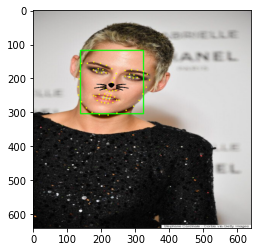

In [24]:
# 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 결과 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

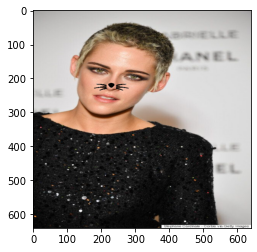

In [25]:
# bounding box, landmark 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### - 스티커 회전해서 붙이기

얼굴의 각도에 따라 스티커의 각도도 변하게 하고 싶어서 스티커를 회전하였다. 이미지를 회전시킬 각도는 계산하려고 하였으나 결국 방법을 찾지 못하였다. 대충 이미지가 -30도 정도 회전한 것 같아 각도를 -30도로 설정하였다. 이미지를 회전하는 코드는 [여기](https://076923.github.io/posts/Python-opencv-6/)를 참고하였다.

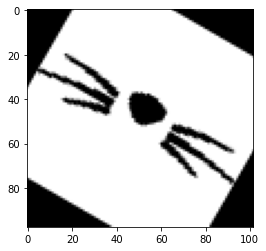

In [26]:
# 각도 계산

# 스티커 회전
matrix = cv2.getRotationMatrix2D((w/2,h/2), -30, 1)
img_sticker= cv2.warpAffine(img_sticker, matrix, (w, h))
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

회전한 스티커를 원본이미지에 적용하였다. 그러나 스티커를 회전한 후 보이는 검은 부분도 같이 나왔다. 검은 부분을 제거하고 싶었으나 방법을 알지 못하였다.

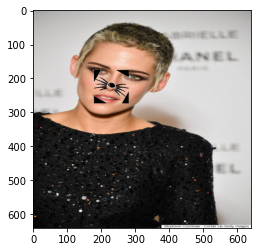

In [27]:
# bounding box, landmark 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 문제점 찾기

### 문제점과 해결책

- 사진의 사이즈     
  사진의 bounding box를 찾지 못하여 사진의 사이즈를 변경했더니 찾을 수 있는 경우도 있었다. 즉 사진의 사이즈가 얼굴 검출에 영향을 미침을 알 수 있다. 
  

- 얼굴 각도가 다른 사진         
  얼굴의 각도가 달라지면 스티커의 각도도 달라져야 한다. 위의 예와 같이 스티커를 회전하면 해결할 수 있다.      


- 멀리 있는 사진    
  멀리 있는 사진도 어느 정도 까지는 얼굴 검출을 하였으나 더 멀리 떨어져 있으면 얼굴의 좌표를 구하기 어려워서 찾지 못하는 것 같다. 이미지 피라미드로 이미지를 확대하여 얼굴의 좌표를 찾으면 얼굴 검출을 할 수 있을 것이다. (이미지 확대는 못 하였다.)      
![](https://images.velog.io/images/guide333/post/5955b071-13bf-444d-a80b-44fbbbe1f5fd/Screenshot%20from%202021-01-17%2001-31-30.png)

- 여러 명이 같이 있는 사진
  LMS에 써 있는 코드를 그대로 쓰면 bounding box는 찾을 수 있으나 landmark는 1명만 나온다. 슬랙에 올라온 글을 참조하여 ```for idx, point in enumerate(list_points):```에서 ```for idx, point in enumerate(landmark):```로 바꾸었더니 landmark를 모두 찾을 수 있었다. 
  얼굴의 스티커의 크기와 각각의 얼굴에서 스티커를 붙일 위치를 변경한다면 모든 얼굴에 스티커를 붙일 수 있을 것이다. 그러나 실제로 코드를 작성하지는 못했다.
![](https://images.velog.io/images/guide333/post/3c1d57fd-aec4-438c-8ef7-893b54ca2c56/Screenshot%20from%202021-01-17%2001-01-27.png)
 
- 누워 있는 사진
  - 누워 있는 사진을 여러 장 실험해 보았다. 옆으로 누웠거나 위로 누운 경우는 얼굴 검출을 못하였다. 특이하게도 아래의 그림은 bounding box는 찾지 못하였으나 facial landmark를 바닥에서 찾았다. 왜 이렇게 되는지 궁금하다. 
![](https://images.velog.io/images/guide333/post/f8df8f45-a818-412a-832c-d3df6b258eef/Screenshot%20from%202021-01-12%2017-46-03.png)
  - 아래 사진과 같이 옆으로 팔을 기대고 누워 있는 사진은 얼굴 검출을 하였으나 얼굴이 정면을 보고 있지 않아서인지, 스티커가 찌그러지는 현상을 보였다. 
  ![](https://images.velog.io/images/guide333/post/3407c890-3168-4a9e-877a-7bb829779f1c/Screenshot%20from%202021-01-12%2017-47-44.png)
  - 위의 두 경우를 볼 때, 어떻게 있든 자세는 상관 없고, 얼굴의 이목구비와 연관된 것 같다는 생각이 들었다. 얼굴의 이목구비가 모두 보이고 이목구비의 좌표가 주어진 모델(ibub 300-W 데이터셋으로 학습한 pretrained model)과 같으면 얼굴 검출을 할 수 있다.
  
  
- 더러운 얼굴 사진     
  얼굴에 무엇인가 묻으면 인식하는지를 실험해 보았는데, 이목구비가 모두 보여서인지 얼굴 검출을 하였다. 그러나 얼굴을 왼쪽으로 틀어져 있어 스티커가 얼굴 바깥으로 나갔다.
 ![](https://images.velog.io/images/guide333/post/d4366b26-5909-4228-af70-f3bc1601bbc8/Screenshot%20from%202021-01-12%2017-48-00.png)
- 이미지의 밝기      
  밝기를 변경하였을 때 이목구비가 보이는 사진들은 얼굴 검출을 하였으나, 너무 어둡거나 밝아 이목구비가 모두 보이지 않는 경우는 찾지 못하였다. 
 ![](https://images.velog.io/images/guide333/post/d0bc73fb-3f72-4152-a59f-7487564537cd/Screenshot%20from%202021-01-12%2017-48-18.png)
 ![](https://images.velog.io/images/guide333/post/0fd0eb4f-6649-4c22-8c46-fb7e606feae6/Screenshot%20from%202021-01-12%2017-48-37.png)

- 눈을 감고 있는 사진   
  눈을 감고 있거나 웃어서 눈이 접힌 경우에도 얼굴 검출을 하였다. 특히 피부색이 검은 경우, 육안으로는 이목구비가 잘 보이지 않는 부분이 있지만 얼굴 검출을 하는 것이 신기했다.
  ![](https://images.velog.io/images/guide333/post/cf2c9456-3df0-4894-9468-65c09ea757ad/Screenshot%20from%202021-01-12%2017-54-10.png)
![](https://images.velog.io/images/guide333/post/6c46dd23-dccb-47b8-9086-00a1e3c7df2b/Screenshot%20from%202021-01-12%2019-36-52.png)
![](https://images.velog.io/images/guide333/post/39d5ea5d-b6f0-429c-857b-127d9bc5570a/Screenshot%20from%202021-01-12%2019-36-43.png)

  
### 결론
- 다양한 사진을 가지고 실험을 해 보았을 때, 이목구비가 조금씩이라도 모두 나올 경우에만 bounding box와 facial landmark를 찾는 것 같다. 이목구비 중 하나가 잘 나오지 않는 경우(마스크를 끼거나 옆얼굴만 나온 경우)나 얼굴이 너무 작은 경우에는 얼굴 검출을 할 수 없었다. 이목구비의 좌표를 찾을 수 없어서가 그 이유인 것 같다. 
- 얼굴의 위치가 위아래가 아니라 다른 방향일 때(뒤집은 얼굴이나 얼굴이 왼쪽이나 오른쪽으로 누워 있는 경우) 얼굴 검출을 할 수 없었다. 주어진 모델에서 벗어나는 경우에도 얼굴 검출이 안 되는 것 같다.
- 얼굴을 왼쪽이나 오른쪽으로 트는 경우에는 얼굴 검출을 하나 얼굴 왼쪽과 오른쪽의 비율이 같지 않아서 스티커가 찌그러 지거나 얼굴 밖으로 튀어 나간다. 스티커의 좌표를 조정하면 제대로 나올 것 같은 생각은 드는데, 왼쪽과 오른쪽의 비율을 찾고 조정하는 것이 쉽지는 않을 것 같다. 
- 얼굴의 각도에 따라 스티커의 각도도 결정해 주어야 한다. 이미지의 회전 각도는 얼굴의 각도와 연결되게 할 수 있을 것 같다. 
- 사진의 사이즈에 따라 얼굴 검출을 할 수도, 못할 수도 있었다. 얼굴 검출을 위해서는 이미지의 사이즈 역시 중요하다. 

### 질문
    
1. 실행 속도가 중요할까?    
   얼굴을 인식하는 시간이 너무 오래 걸린다면 소비자들은 이 앱이 제대로 작동하지 않는 줄 알고 이 앱을 사용하지 않을 것이다. LMS에서 주어진 알고리즘을 사용하면 얼굴 검출을 하고 스티커를 붙이는 것은 빨리 실행되었다.    
   
2. 스티커앱을 만들 때 정확도가 얼마나 중요할까?    
   다양한 인물 사진에서 얼굴 검출을 제대로 하지 못하여 스티커를 붙이지 못한다면 사용자들은 이 앱을 사용하지 않을 것이다. 다양한 사이즈, 다양한 포즈, 사진의 밝기나 거리, 그리고 많은 사람이 한 사진에 있는 경우 등 다양한 상황에서 얼굴 인식을 해내는 것이 중요하다. LMS에 주어진 알고리즘으로는 다양한 상황에서 얼굴 인식을 하지 못하는 경우가 있으므로 스티커 앱으로서의 실용성은 적은 것 같다. 각각의 경우에 부합하는 알고리즘을 추가하여 모든 상황에서 얼굴 인식을 할 수 있는 앱을 만들면 좋겠다. 

# 후기
- 이번 프로젝트에서 **어려웠던 점** 
  1. 스티커와 스티커를 붙일 곳의 좌표 설정
  2. np.where()
  3. 스티커 각도 변화
  4. opencv 의 cv2.addWeighted()    
  
  
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점** 
  - 얼굴 검출에 있어서 필요한 조건
  - 각 코드의 의미와 변수 변경
  - 얼굴의 각도 계산: 아직 방법을 모름
        
        
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**         
    1번(원본과 스티커 사진이 정확히 합성)/ 2번(고양이 수염의 위치가 원본 얼굴에 어울리게 출력)의 지표를 맞추기 위해 배운 내용을 꼼꼼히 보고 코드를 썼고, 좌표나 사이즈 문제는 landmark 그림을 보고 좌표 계산을 하여 해결하였다.    
    3번(변수에 다른 영향도 분석)을 위해서는 다양한 사진을 찾아 실행해 보았다. 
         
    
- **자기 다짐**            
    이번 프로젝트는 빨리 끝낼 수 있을 것이라 생각했으나 스티커의 각도를 변화시키는 법과 opencv 의 cv2.addWeighted)의 사용법을 찾고 적용하느라 시간이 오래 걸렸다. 온라인으로 해서 말로만 설명을 들으려니 더 헤맸던 것 같다. 그래도 도움을 주신 분들이 있어서 감사했다.       
    아직도 코드를 보고 분석하는 능력이 부족한 것 같다. 코드가 무엇을 의미하는지나 코드 내 어떤 부분을 바꿔줘야 하는지에 대해서는 잘 몰라서 헤매는 경우가 많다. 더 많은 것을 배우고 익혀서 코드를 보고서 이해할 수 있었으면 좋겠다. 
    